### Ensemble Methods

*   Bagging
*   Random Forest
*   Gradient Boosting
*   Neural Networks



### Capital Bikeshare Data
https://ride.capitalbikeshare.com/system-data

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Read csv files

df_Feb = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/202402-capitalbikeshare-tripdata.csv')
df_Mar = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/202403-capitalbikeshare-tripdata.csv')
df_Apr = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/202404-capitalbikeshare-tripdata.csv')

# concat data
df=pd.concat([df_Feb, df_Mar,df_Apr])

In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,24DBACC298E33BF6,electric_bike,2024-02-01 21:18:50,2024-02-01 21:27:36,Eckington Pl & Q St NE,31505.0,5th & K St NW,31600.0,38.910893,-77.005023,38.90304,-77.019027,member
1,FE1067800A18BC56,electric_bike,2024-02-06 17:15:33,2024-02-06 17:30:33,4th & C St SW,31243.0,NaN,NaN,38.886443,-77.017388,38.91000,-76.980000,member
2,AD1962B215B5879D,electric_bike,2024-02-26 13:19:42,2024-02-26 13:30:44,North Capitol St & F St NW,31624.0,NaN,NaN,38.896907,-77.009684,38.90000,-77.010000,member
3,3F8352E6D9EC4F85,electric_bike,2024-02-02 11:01:22,2024-02-02 11:05:14,1st & K St NE,31662.0,NaN,NaN,38.902394,-77.005614,38.90000,-77.010000,member
4,D656DA87FA915F14,electric_bike,2024-02-25 08:28:18,2024-02-25 08:48:44,Virginia Ave & 25th St NW,31297.0,NaN,NaN,38.898456,-77.053075,38.91000,-77.060000,member


## Let's consider the GWSB station "22nd & H St NW"

### Bike Availability: Number of Pickups

In [4]:
# Convert the 'started_at' column to datetime objects
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date

# Filter for trips started at '22nd & H St NW'
PU_trips = df[df['start_station_name'] == '22nd & H St NW']

# Group by date and count the trips
PU_counts = PU_trips.groupby('started_at_date')['started_at_date'].count()

PU_counts

,started_at_date
started_at_date,
2024-02-01,33
2024-02-02,23
2024-02-03,22
2024-02-04,18
2024-02-05,19
...,...
2024-04-26,33
2024-04-27,18
2024-04-28,36


### Dock Availability: Number of Dropoffs

In [5]:
# Convert the 'ended_at' column to datetime objects
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

# Filter for trips ended at '22nd & H St NW'
DO_trips = df[df['end_station_name'] == '22nd & H St NW']

# Group by date and count the trips
DO_counts = DO_trips.groupby('ended_at_date')['ended_at_date'].count()

DO_counts

,ended_at_date
ended_at_date,
2024-02-01,33
2024-02-02,25
2024-02-03,20
2024-02-04,19
2024-02-05,23
...,...
2024-04-26,39
2024-04-27,24
2024-04-28,28


## Merge PU and DO tables
- For each day, we look at the numbers of pickups and dropoffs

In [6]:
# merge PU_counts and DO_counts by matching the dates, and change the column names to PU_count and DO_count respectively.

PU_DO_counts = pd.merge(PU_counts, DO_counts, left_index=True, right_index=True, how='outer')
PU_DO_counts = PU_DO_counts.rename(columns={'started_at_date': 'PU_ct', 'ended_at_date': 'DO_ct'})

# change the index name from 'started_at' to 'date'

PU_DO_counts = PU_DO_counts.rename_axis('date')
PU_DO_counts

,PU_ct,DO_ct
date,,
2024-02-01,33,33
2024-02-02,23,25
2024-02-03,22,20
2024-02-04,18,19
2024-02-05,19,23
...,...,...
2024-04-26,33,39
2024-04-27,18,24
2024-04-28,36,28


# Feature Information: Weather Data
- From https://www.visualcrossing.com/weather-history/

In [7]:
df_weather = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/DC_weather_2024.csv')

df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"washington, dc",2024-01-01,43.0,38.9,40.8,41.8,31.4,36.4,33.3,74.7,...,0.9,1,10,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,Overcast,Cloudy skies throughout the day.,cloudy,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
1,"washington, dc",2024-01-02,45.9,35.7,40.4,40.9,27.2,33.8,26.2,57.3,...,8.3,5,10,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
2,"washington, dc",2024-01-03,47.8,33.7,39.9,44.6,27.8,36.4,26.6,59.5,...,9.6,5,10,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,D6279,72403793728,KADW,..."
3,"washington, dc",2024-01-04,46.7,33.2,40.4,41.9,24.1,34.6,25.2,55.2,...,4.8,4,10,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,KADW,KDAA,7..."
4,"washington, dc",2024-01-05,39.9,27.8,33.6,35.8,19.4,28.0,18.9,55.0,...,11.6,5,10,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,D6279,KADW,..."


## Drop variables of your choice

In [8]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])

## Prepare X and y: Merge df_weather with PU_DO_counts

In [9]:
# Convert the 'datetime' column to datetime objects and extract the date
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['date'] = df_weather['datetime'].dt.date

# Merge the two dataframes based on the 'date' column
merged_df = pd.merge(PU_DO_counts, df_weather, on='date', how='left')

# Prepare training and test data

In [14]:
# we have two target variables: PU_ct and DO_ct
y = merged_df[['PU_ct','DO_ct']]
X = merged_df[['temp','precip','windspeed','uvindex']]
X

,temp,precip,windspeed,uvindex
0,42.4,0.000,12.0,5
1,47.1,0.012,19.1,2
2,42.2,0.000,14.7,6
3,41.7,0.000,9.2,6
4,41.0,0.000,12.2,6
...,...,...,...,...
85,55.2,0.000,15.4,9
86,55.7,0.032,10.0,2
87,67.0,0.000,10.0,9
88,75.2,0.000,13.0,9


## <font color="red"> Important: train_test_split with y=['PU_ct','DO_ct']. Why? <font>

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4, random_state = 200) # 40% test data

In [16]:
y_train.head()

,PU_ct,DO_ct
73,26,24
60,26,22
18,10,15
44,19,20
4,19,23


## In this example, we predict 'PU_ct' using Ensemble Methods.

# Regression Tree

In [17]:
from sklearn.tree import DecisionTreeRegressor
regr_tree = DecisionTreeRegressor(max_depth=3)
model=regr_tree.fit(X_train,y_train['PU_ct'])

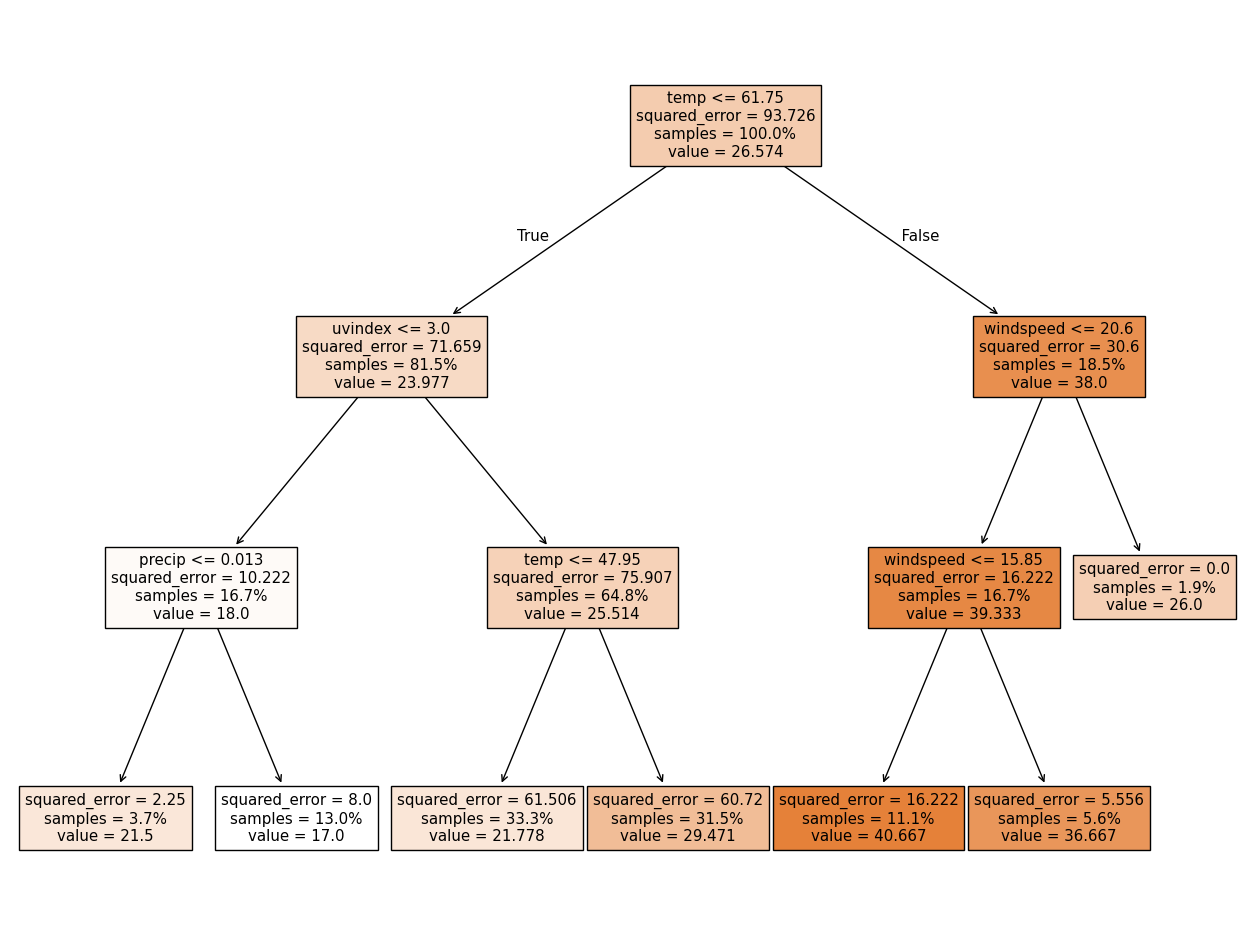

In [18]:
# Visualize classification tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fn = list(X_train.columns) # specify feature names
plt.figure(figsize = (16,12))
plot_tree(regr_tree, feature_names = fn, filled = True, proportion=True);

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error

y_pred=regr_tree.predict(X_test)
mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
print(f"MSE is {mse}")

MSE is 54.742


## Bagging
- A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- Bagging Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
- Bagging Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor

In [24]:
from sklearn.ensemble import BaggingRegressor
# default estimator is decision tree
# n_estimator: The number of base estimators in the ensemble.
regr_bag = BaggingRegressor(n_estimators=10, random_state=0).fit(X_train, y_train['PU_ct'])

In [26]:
y_pred=regr_bag.predict(X_test)
mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
print(f"MSE is {mse}")

MSE is 74.25


### Bagging does not overfit as the number of trees increases

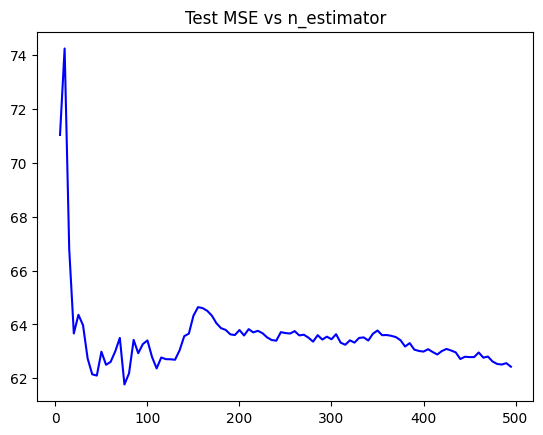

In [27]:
mse_list = []
n_list = np.arange(5,500,5)
for n in n_list:
    regr_bag = BaggingRegressor(n_estimators=n,random_state=0).fit(X_train, y_train['PU_ct'])
    y_pred=regr_bag.predict(X_test)
    mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
    mse_list.append(mse)

plt.plot(n_list, mse_list,  color = 'blue', markerfacecolor = 'black',label = 'Test MSE')
plt.title('Test MSE vs n_estimator')
plt.show()

## Random Forest

- Classification: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- Regression: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [28]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [29]:
regr_RF = RandomForestRegressor(n_estimators=10, random_state=0).fit(X_train, y_train['PU_ct'])

In [31]:
y_pred=regr_RF.predict(X_test)
mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
print(f"MSE is {mse}")

MSE is 75.641


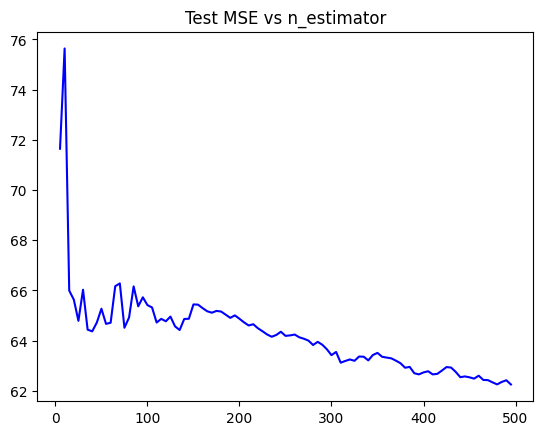

In [33]:
mse_list = []
n_list = np.arange(5,500,5)
for n in n_list:
    regr_RF = RandomForestRegressor(n_estimators=n,random_state=0).fit(X_train, y_train['PU_ct'])
    y_pred=regr_RF.predict(X_test)
    mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
    mse_list.append(mse)

plt.plot(n_list, mse_list,  color = 'blue', markerfacecolor = 'black',label = 'Test MSE')
plt.title('Test MSE vs n_estimator')
plt.show()

### Feature Importance

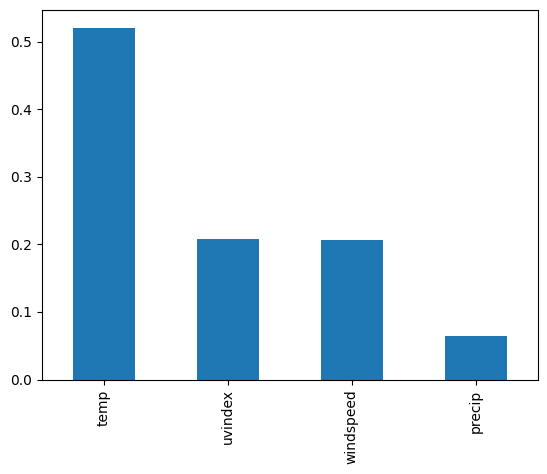

In [35]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(regr_RF.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

### Hyperparameter tuning for RF

In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2',None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train['PU_ct'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 2,
 'bootstrap': True}

In [42]:
best_rf = rf_random.best_estimator_

In [45]:
y_pred=best_rf.predict(X_test)
mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
print(f"MSE is {mse}")

MSE is 58.8


## Gradient Boosting

- Classification: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- Regression: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

regr_GB = GradientBoostingRegressor(learning_rate=0.1, random_state=0).fit(X_train, y_train['PU_ct'])

In [49]:
y_pred=regr_GB.predict(X_test)
mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
print(f"MSE is {mse}")

MSE is 99.322


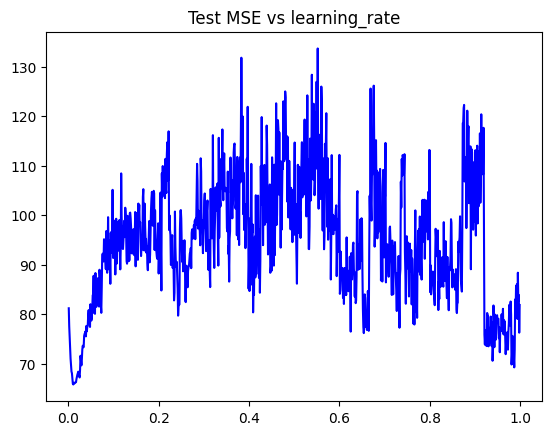

In [50]:
mse_list = []
rate_list = np.arange(0.001,1,0.001)
for rate in rate_list:
    regr_GB = GradientBoostingRegressor(learning_rate=rate, verbose=0).fit(X_train, y_train['PU_ct'])
    y_pred=regr_GB.predict(X_test)
    mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
    mse_list.append(mse)

plt.plot(rate_list, mse_list,  color = 'blue', markerfacecolor = 'black',label = 'Test MSE')
plt.title('Test MSE vs learning_rate')
plt.show()

## XGBoost

In [51]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [53]:
param_grid = {"max_depth":    [1, 2 , 3, 4, 5],
              "n_estimators": [20, 50 ,100, 200, 500, 800, 1000],
              "learning_rate": [0.01,  0.015, 0.05 , 0.1]}

regressor = xgb.XGBRegressor()
search = GridSearchCV(regressor, param_grid, cv=10).fit(X_train, y_train['PU_ct'])

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}


In [55]:
regr_xgb=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

regr_xgb.fit(X_train, y_train['PU_ct'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
y_pred=regr_xgb.predict(X_test)
mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
print(f"MSE is {mse}")

MSE is 62.399


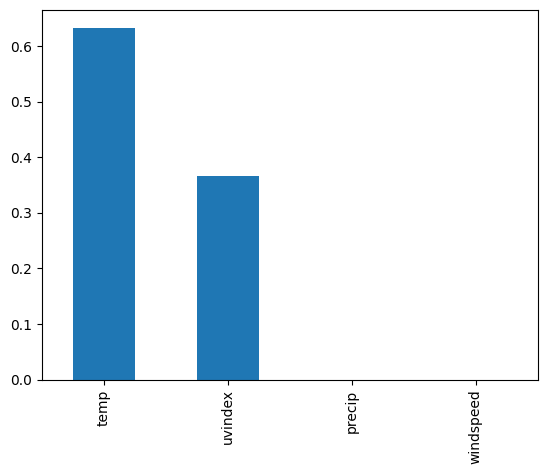

In [58]:
feature_importances = pd.Series(regr_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

## Neural Network

- https://www.ibm.com/topics/neural-networks

- Explanation on Youtube: https://youtu.be/aircAruvnKk


### Tensorflow Implementation

In [59]:
from tensorflow.keras.models import Sequential # put layers together
from tensorflow.keras.layers import Dense # define the layer

In [62]:
# define the keras model
regr_nn = Sequential()
regr_nn.add(Dense(20,  activation='relu'))
regr_nn.add(Dense(10, activation='relu'))
regr_nn.add(Dense(10, activation='relu'))
regr_nn.add(Dense(1, activation='linear')) # linear for regression; sigmoid/softmax for classification

In [63]:
# compile the keras model
regr_nn.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])

In [64]:
# fit the keras model on the dataset
regr_nn.fit(X_train, y_train['PU_ct'], epochs=100, batch_size=10)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - MeanSquaredError: 328.9389 - loss: 328.9389
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanSquaredError: 286.3090 - loss: 286.3090  
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanSquaredError: 193.2360 - loss: 193.2360  
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanSquaredError: 141.1197 - loss: 141.1197 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanSquaredError: 119.9193 - loss: 119.9193 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanSquaredError: 96.7846 - loss: 96.7846   
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanSquaredError: 74.3858 - loss: 74.3858 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanSquaredError: 59.1445 - loss: 59.1445 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanSquaredError: 64.1385 - loss: 64.1385 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanSquaredError: 68.4384 - loss: 68.4384  
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

In [65]:
y_pred=regr_nn.predict(X_test)
mse = round(mean_squared_error(y_test['PU_ct'], y_pred),3)
print(f"MSE is {mse}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
MSE is 56.834
